# Normal Bigrams without NNs

In [2]:
bigrams = {}
words = open("../names.txt", "r").read().splitlines()
for word in words:
    word_chars = ["<S>"] + list(word) + ["<E>"]
    for ch1, ch2 in zip(word_chars, word_chars[1:]):
        bigram = (ch1, ch2)
        bigrams[bigram] = bigrams.get(bigram, 0) + 1

# sorted(bigrams.items(), key=lambda key_val: key_val[1], reverse=True)

In [3]:
import torch
import matplotlib.pyplot as plt

# Create bigram matrix
words = open("../names.txt", "r").read().splitlines()
chars = sorted(list(set("".join(words))))
char_to_indx = {char: indx for indx, char in enumerate(chars)}
char_to_indx["."] = 26
bigrams = torch.zeros([len(char_to_indx), len(char_to_indx)], dtype=torch.int32)
bigrams += 1 # smooth probabilities(at traning time) by making sure the minimum ammout of counts a bigram has is 1 or bigger.

for word in words:
    word_chars = ["."] + list(word) + ["."]
    for char1, char2 in zip(word_chars, word_chars[1:]):
        char1_indx = char_to_indx[char1]
        char2_indx = char_to_indx[char2]
        bigrams[char1_indx, char2_indx] += 1


(-0.5, 26.5, 26.5, -0.5)

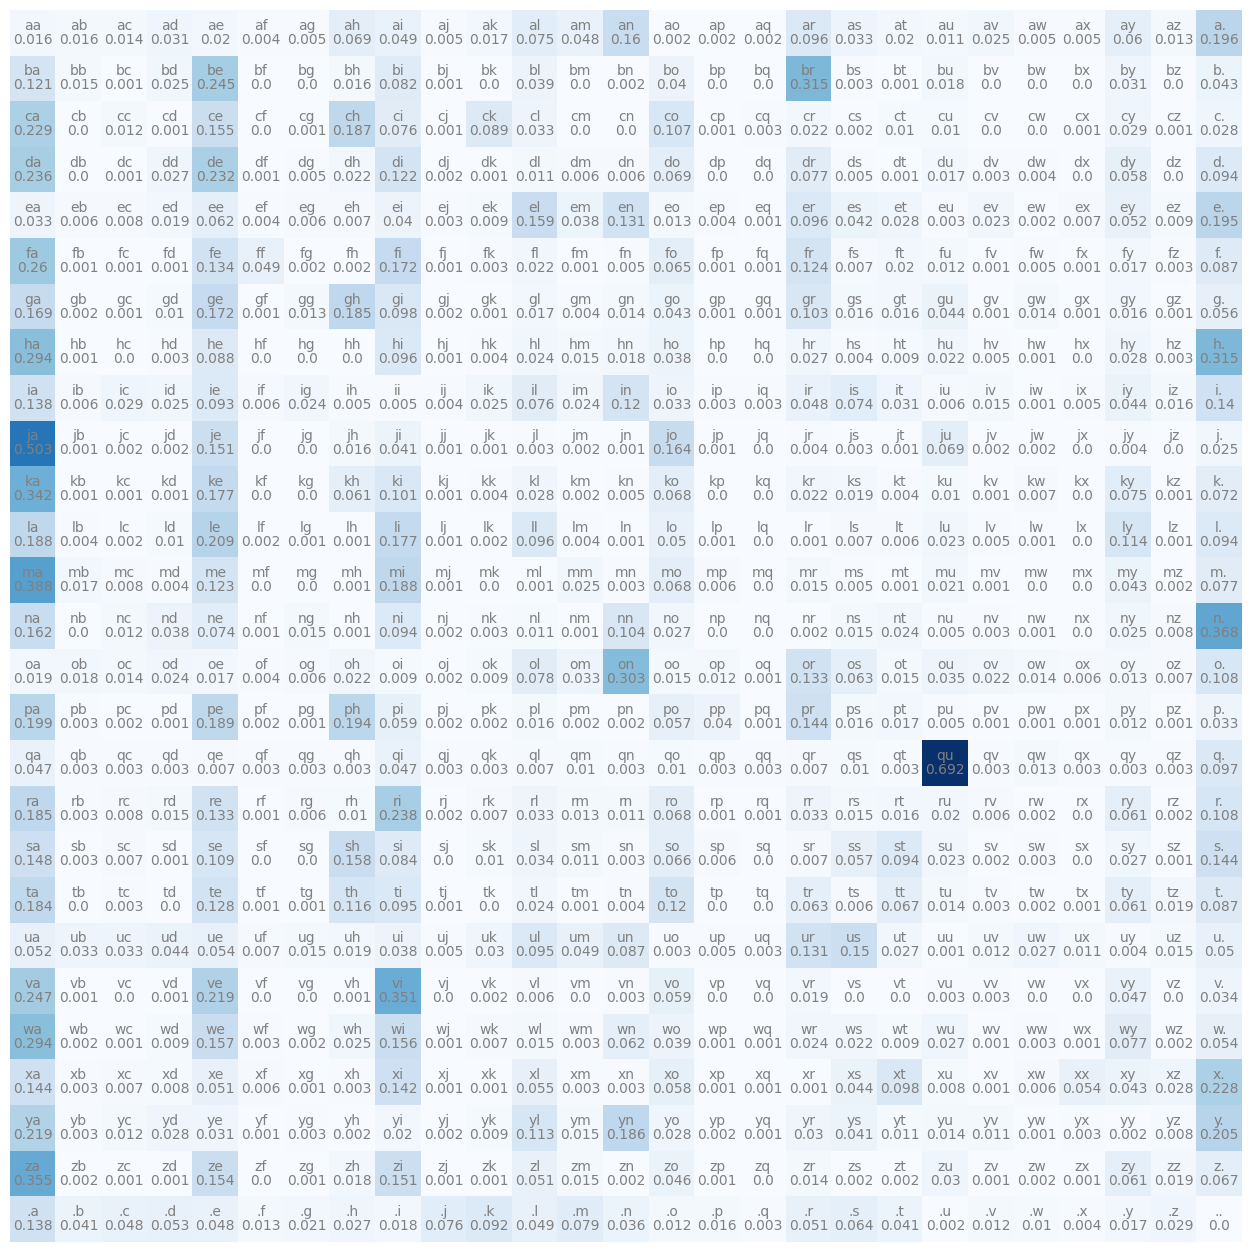

In [4]:
# Plot bigram matrix
bigrams_probs = bigrams.clone().float()
bigrams_probs /= bigrams_probs.sum(1, keepdim=True)
    
indx_to_char = {indx: char for char, indx in char_to_indx.items()}
plt.figure(figsize=(16, 16))
plt.imshow(bigrams_probs, cmap="Blues")
for row_indx in range(bigrams_probs.shape[0]):
    for column_indx in range(bigrams_probs.shape[1]):
        char_str = indx_to_char[row_indx] + indx_to_char[column_indx]
        plt.text(column_indx, row_indx, char_str, ha="center", va="bottom", color="gray")
        plt.text(column_indx, row_indx, round(bigrams_probs[row_indx][column_indx].item(), 3), ha="center", va="top", color="gray") # Display probabilities
        # plt.text(column_indx, row_indx, bigrams[row_indx, column_indx].item(), ha="center", va="bottom", color="gray") # Display counts.

plt.axis("off")

In [5]:
import torch
import torch.nn.functional as torch_func

gen = torch.Generator().manual_seed(2147483647)
all_probs = (bigrams + 1).float() # bigrams + 1 is done for model smoothing to ensure that there are not 0 probabilities since even though a combination of leeters wans't found in the dataset, it doesn't necessarly mean that it doesn't exist outside of the dataset.
all_probs /= all_probs.sum(1, keepdim=True)

for _ in range(20):
    out = []
    indx = bigrams.shape[0] - 1
    while True:
        indx = torch.multinomial(all_probs[indx], num_samples=1, replacement=True, generator=gen).item()
        out.append(indx_to_char[indx])
        if indx == bigrams.shape[0] - 1:
            break

    print(''.join(out))

ka.
kenen.
lyri.
ara.
gri.
beonaneiasaupide.
tah.
r.
anenoubd.
kanan.
jadaecenjos.
jana.
to.
zadr.
mbeli.
ghenvilizgaeunn.
a.
gout.
kiri.
b.


In [6]:
log_likelihood = 0.0
num_bigrams = 0

for word in words:
    word_chars = ["."] + list(word) + ["."]
    for char1, char2 in zip(word_chars, word_chars[1:]):
        char1_indx = char_to_indx[char1]
        char2_indx = char_to_indx[char2]
        prob = all_probs[char1_indx, char2_indx]
        log_prob = torch.log(prob)
        log_likelihood += log_prob
        num_bigrams += 1


print(f"{log_likelihood = }")
neg_log_likelihood = -log_likelihood
print(f"{neg_log_likelihood = }")
print(f"{neg_log_likelihood / num_bigrams}")

log_likelihood = tensor(-560623.6875)
neg_log_likelihood = tensor(560623.6875)
2.4553112983703613


# Create Training Data Set for Neural Network

In [7]:
xs = []
ys = []

for word in words:
    word_chars = ["."] + list(word) + ["."] # Adding starting and ending chars which '.' represents, ex. "cat" -> ".cat."

    # Creating inputs and labels from the current word
    for char1, char2 in zip(word_chars, word_chars[1:]):
        char1_indx = char_to_indx[char1]
        char2_indx = char_to_indx[char2]
        xs.append(char1_indx)
        ys.append(char2_indx)

enc_xs = torch_func.one_hot(
    torch.tensor(xs),
    num_classes = bigrams.shape[0]
).float()
enc_xs.requires_grad_ = True
enc_ys = torch_func.one_hot(
    torch.tensor(ys),
    num_classes = bigrams.shape[0]
).float()
enc_ys.requires_grad_ = True

# Train Neural Network on Training Data

In [8]:
# Init weights
W = torch.randn((bigrams.shape[0], bigrams.shape[0]), requires_grad=True)

In [9]:
EPOCHS = 200
LEARNING_RATE = 20

for _ in range(EPOCHS):
    # Forward pass
    logits = enc_xs @ W # Log counts

    # Cost funcion (Softmax)
    counts = logits.exp() # Equivilant of a row in the Bigram marix above
    probs = counts / counts.sum(1, keepdim=True)

    # Calculating loss and printing it
    neg_log_likelihood = -probs[torch.arange(probs.shape[0]), ys].log() + 0.01 * (W**2).mean()
    loss = neg_log_likelihood.mean()
    print(f"{loss.item() = }")

    # Backpropogation
    W.grad = None # zeroing grads
    loss.backward()

    # Update weights
    W.data += -LEARNING_RATE * W.grad





loss.item() = 3.7973501682281494
loss.item() = 3.618779420852661
loss.item() = 3.481766939163208
loss.item() = 3.37231183052063
loss.item() = 3.283005475997925
loss.item() = 3.208563804626465
loss.item() = 3.1451618671417236
loss.item() = 3.0902109146118164
loss.item() = 3.042029619216919
loss.item() = 2.9994959831237793
loss.item() = 2.961796760559082
loss.item() = 2.9282853603363037
loss.item() = 2.89841628074646
loss.item() = 2.871716022491455
loss.item() = 2.8477718830108643
loss.item() = 2.826220750808716
loss.item() = 2.8067495822906494
loss.item() = 2.7890894412994385
loss.item() = 2.7730095386505127
loss.item() = 2.7583158016204834
loss.item() = 2.744842529296875
loss.item() = 2.732450485229492
loss.item() = 2.7210187911987305
loss.item() = 2.71044659614563
loss.item() = 2.7006452083587646
loss.item() = 2.6915371417999268
loss.item() = 2.683056592941284
loss.item() = 2.6751437187194824
loss.item() = 2.6677467823028564
loss.item() = 2.6608190536499023
loss.item() = 2.65431976318

(-0.5, 26.5, 26.5, -0.5)

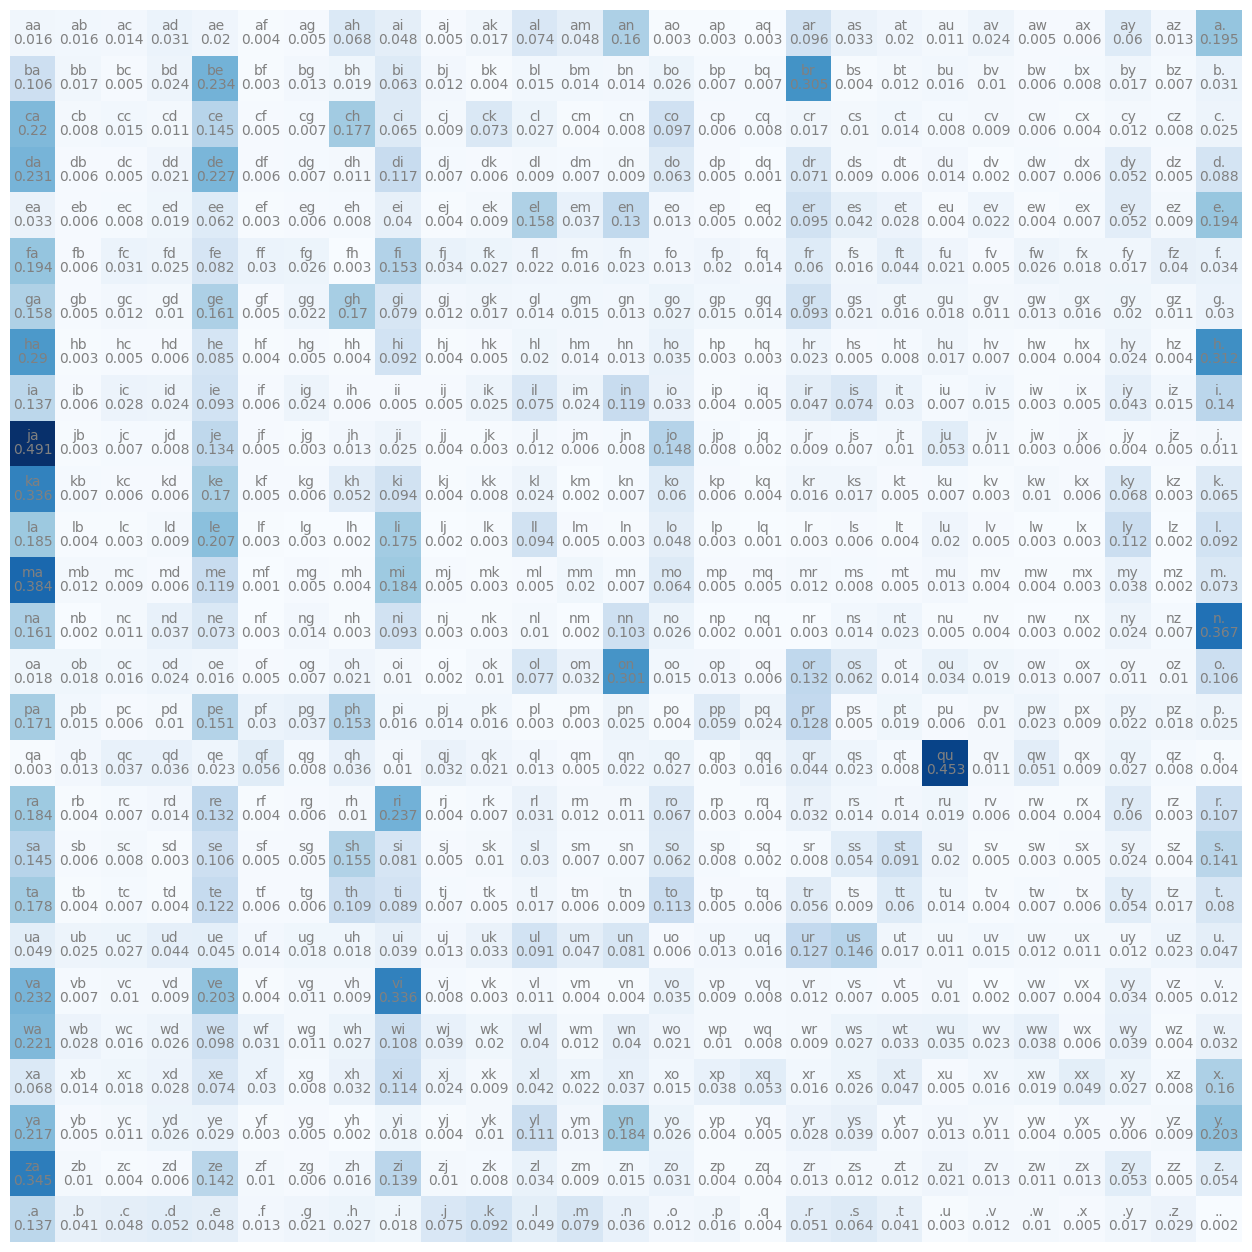

In [11]:
# Graphing probabilities to compare to traditional statistical method done above.
counts = W.exp()
final_probs = counts / counts.sum(1, keepdim=True)

indx_to_char = {indx: char for char, indx in char_to_indx.items()}
plt.figure(figsize=(16, 16))
plt.imshow(final_probs.detach(), cmap="Blues")
for row_indx in range(final_probs.shape[0]):
    for column_indx in range(final_probs.shape[1]):
        char_str = indx_to_char[row_indx] + indx_to_char[column_indx]
        plt.text(column_indx, row_indx, char_str, ha="center", va="bottom", color="gray")
        plt.text(column_indx, row_indx, round(final_probs[row_indx, column_indx].item(), 3), ha="center", va="top", color="gray")

plt.axis("off")

In [26]:
# Sample names from the neural network. AKA inference.
import torch
import torch.nn.functional as torch_func

gen = torch.Generator().manual_seed(2147483647)

start_char_num = W.shape[0] - 1
end_char_num = W.shape[0] - 1
for _ in range(20):
    out = ""
    char_num = start_char_num
    while True:
        one_hot_enc = torch_func.one_hot(torch.tensor(char_num), num_classes=W.shape[0]).float()
        logits = one_hot_enc @ W # Log(base e) counts
        counts = logits.exp()
        probs = counts / counts.sum()
        char_num = torch.multinomial(all_probs[char_num], num_samples=1, replacement=True, generator=gen).item()
        out += indx_to_char[char_num]
        if char_num == end_char_num:
            break

    print(out)

ka.
kenen.
lyri.
ara.
gri.
beonaneiasaupide.
tah.
r.
anenoubd.
kanan.
